<a href="https://colab.research.google.com/gist/david4096/8aff9cec05af0d8ebe6c47dfffe4e34a/networkx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdflib
!pip install networkx
!pip install numpy
!pip install matplotlib
!pip install croissant-rdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.8 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=d150c44802038c1e9116d2286edfb199457c3c997171d7b1762821fe6a2ab67b
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1


In [2]:
import rdflib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

__author__ = "James Wilsenach"

In [3]:
!huggingface-rdf

[2025-03-17 23:19:31,444] INFO: Searching 10 datasets metadata.
[2025-03-17 23:19:31,639] INFO: Retrieved 10 datasets ID.
Fetching datasets metadata ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:04
[2025-03-17 23:19:35,813] INFO: Retrieved Croissant metadata JSON-LD for 10 datasets in 4.37s
[2025-03-17 23:19:35,813] INFO: Loading Croissant metadata JSON-LD to RDF graph. Total items: 10, Chunk size: 1
Parsing data ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
[2025-03-17 23:19:36,034] INFO: Parsing completed in 0.22s, writing 4326 RDF triples to file croissant_metadata.ttl
[2025-03-17 23:19:36,204] INFO: Serialization completed in 0.17s


In [4]:
# Load RDF Graph
g = rdflib.Graph()
g.parse("croissant_metadata.ttl", format="turtle")  # Replace with your Turtle file

<Graph identifier=N68dbc7bca06545319487eca8c1c00247 (<class 'rdflib.graph.Graph'>)>

In [5]:
# Map predicates to unique integer values
predicate_map = {p: i for i, p in enumerate(set(g.predicates()))}


inverse_predicate_map = {v: k for k, v in predicate_map.items()}
creatorid = [predicate_map[k] for k in predicate_map if k if 'creator' in str(k)][0]
nameid = [predicate_map[k] for k in predicate_map if k if 'name' in str(k)][0]
keywordid = [predicate_map[k] for k in predicate_map if k if 'keyword' in str(k)][0]
print(creatorid)

16


In [6]:
# Create a directed graph
G = nx.DiGraph()
creators = {}

creatornames = {}
# Add edges with integer labels
for subj, pred, obj in g:
    if predicate_map[pred] == nameid:
        creatornames[subj] = obj

# Add edges with integer labels
for subj, pred, obj in g:
    if predicate_map[pred] in [creatorid]:
        # print(predicate_map[pred])
        G.add_edge(str(creatornames[subj]), str(creatornames[obj]), label='creat')
        # print(pred)
    elif predicate_map[pred] in [keywordid]:
        G.add_edge(str(creatornames[subj]), str(obj), label='key')

In [7]:
# Convert to an undirected simple graph (ignoring multiple edges and directions)
G_simple = nx.Graph(G)

# Check if the simple graph is connected
is_connected =  nx.is_connected(G_simple)
print("The induced simple graph is connected. Proceeding with visualization.")

The induced simple graph is connected. Proceeding with visualization.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


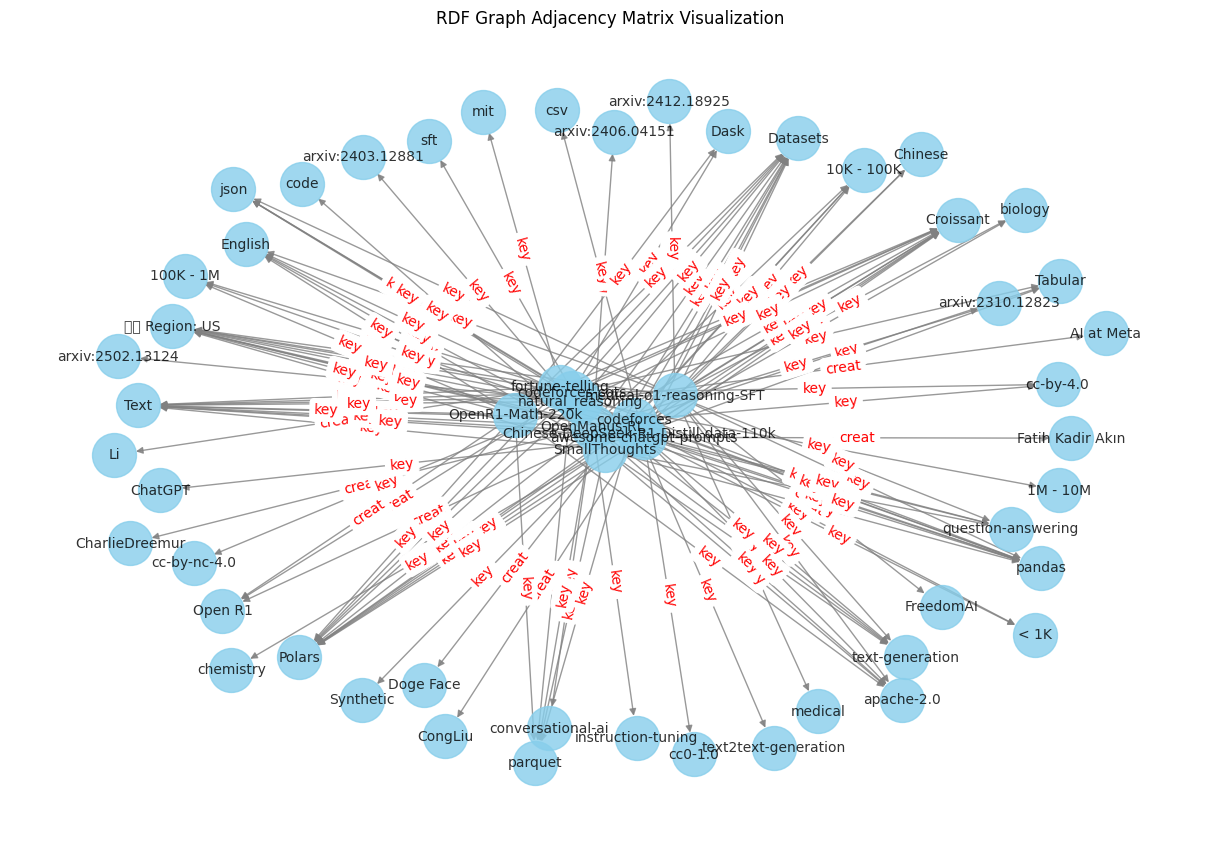

In [8]:
# Layout for visualization
pos = nx.spring_layout(G)

plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000,
        font_size=10, font_color='black', edge_color='gray', width=1, alpha=0.8)

# Draw edge labels (relationship type integers)
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

plt.title("RDF Graph Adjacency Matrix Visualization")
plt.show()

In [9]:
# Convert to adjacency matrix
nodes = list(G.nodes())
adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=int)

for i, src in enumerate(nodes):
    for j, dst in enumerate(nodes):
        if G.has_edge(src, dst):
            adj_matrix[i, j] = G[src][dst]['label']

print("\nAdjacency Matrix:\n", adj_matrix)

ValueError: invalid literal for int() with base 10: 'creat'